# Question 4:

1. Use Gaussian NB from sklearn on UCI Dataset. Plot the decision boundary. Draw
analysis on the results by calculating the Roc curve, and classification report.
2. Now consider all features as correlated and construct a classifier using Mahalanobis
distance. Draw analysis on the results by calculating the Roc curve, and classification
report. Compare the results with part 1. You can refer to this article or book for
Mahalanobis distance.




### Q1. Use Gaussian NB from sklearn on UCI Dataset. Plot the decision boundary. Draw analysis on the results by calculating the Roc curve, and classification report.

- Utility functions for performance analysis after classification

In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'axes.facecolor': 'lightyellow', 'figure.facecolor': 'lightblue'})


def confusionMatrixAndAccuracyReport(Y_test, Y_pred):
    cm = metrics.confusion_matrix(Y_test, Y_pred)
    overallAccuracy = np.trace(cm)/sum(cm.flatten())

    classwiseAccuracy = np.zeros(len(cm))
    for n in range(len(cm)):
        for i in range(len(cm)):
            for j in range(len(cm)):
                if (i != n and j != n) or (i == n and j == n):
                    classwiseAccuracy[n] += cm[i][j]

    classwiseAccuracy /= sum(cm.flatten())

    plt.figure(figsize=(6, 6))
    plt.title('Accuracy Score: {0:3.3f}'.format(overallAccuracy), size=12)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    sns.heatmap(data=cm, annot=True, square=True,  cmap='Blues')

    plt.show()
    print('Overall Accuracy Score: {0:3.3f}'.format(overallAccuracy))
    print('Classwise Accuracy Score: {0}'.format(classwiseAccuracy))


In [2]:
def rocCurveAndAucAnalysis(y_test, y_score):
    n_classes = y_test.shape[1]
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])

    plt.title("ROC Curve")
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2,
             color='r', label='Random', alpha=.8)

    colors = ["aqua", "darkorange", "cornflowerblue"]
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=2,
            label="ROC curve of class {0} (area = {1:0.2f})".format(
                i, roc_auc[i]),
        )

    plt.xlabel("False Positve Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

    for i in range(n_classes):
        print("Area Under the curve for class {} : {}".format(i, roc_auc[i]))


- Data Load

In [3]:
# Data load

data = pd.read_csv('data-ques-4/breast-cancer.data', names=[
    "Class",
    "age",
    "menopause",
    "tumor-size",
    "inv-nodes",
    "node-caps",
    "deg-malig",
    "breast",
    "breast-quad",
    "irradiat"
], header=None)
data.head()

,Class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
0,no-recurrence-events,30-39,premeno,30-34,0-2,no,3,left,left_low,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
2,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no
3,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no
4,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no


- Unique values of different columns

In [4]:
[np.unique(data[col]) for col in data.columns]

[array(['no-recurrence-events', 'recurrence-events'], dtype=object),
 array(['20-29', '30-39', '40-49', '50-59', '60-69', '70-79'], dtype=object),
 array(['ge40', 'lt40', 'premeno'], dtype=object),
 array(['0-4', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39',
        '40-44', '45-49', '5-9', '50-54'], dtype=object),
 array(['0-2', '12-14', '15-17', '24-26', '3-5', '6-8', '9-11'],
       dtype=object),
 array(['?', 'no', 'yes'], dtype=object),
 array([1, 2, 3], dtype=int64),
 array(['left', 'right'], dtype=object),
 array(['?', 'central', 'left_low', 'left_up', 'right_low', 'right_up'],
       dtype=object),
 array(['no', 'yes'], dtype=object)]

- Data pre process

In [48]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

data = data.apply(lambda col: le.fit_transform(col))
data

,Class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
0,0,1,2,5,0,1,2,0,2,0
1,0,2,2,3,0,1,1,1,5,0
2,0,2,2,3,0,1,1,0,2,0
3,0,4,0,2,0,1,1,1,3,0
4,0,2,2,0,0,1,1,1,4,0
...,...,...,...,...,...,...,...,...,...,...
281,1,1,2,5,0,1,1,0,3,0
282,1,1,2,3,0,1,2,0,3,1
283,1,4,0,3,0,1,0,1,3,0
284,1,2,0,5,4,1,2,0,2,0


- Data Exploration

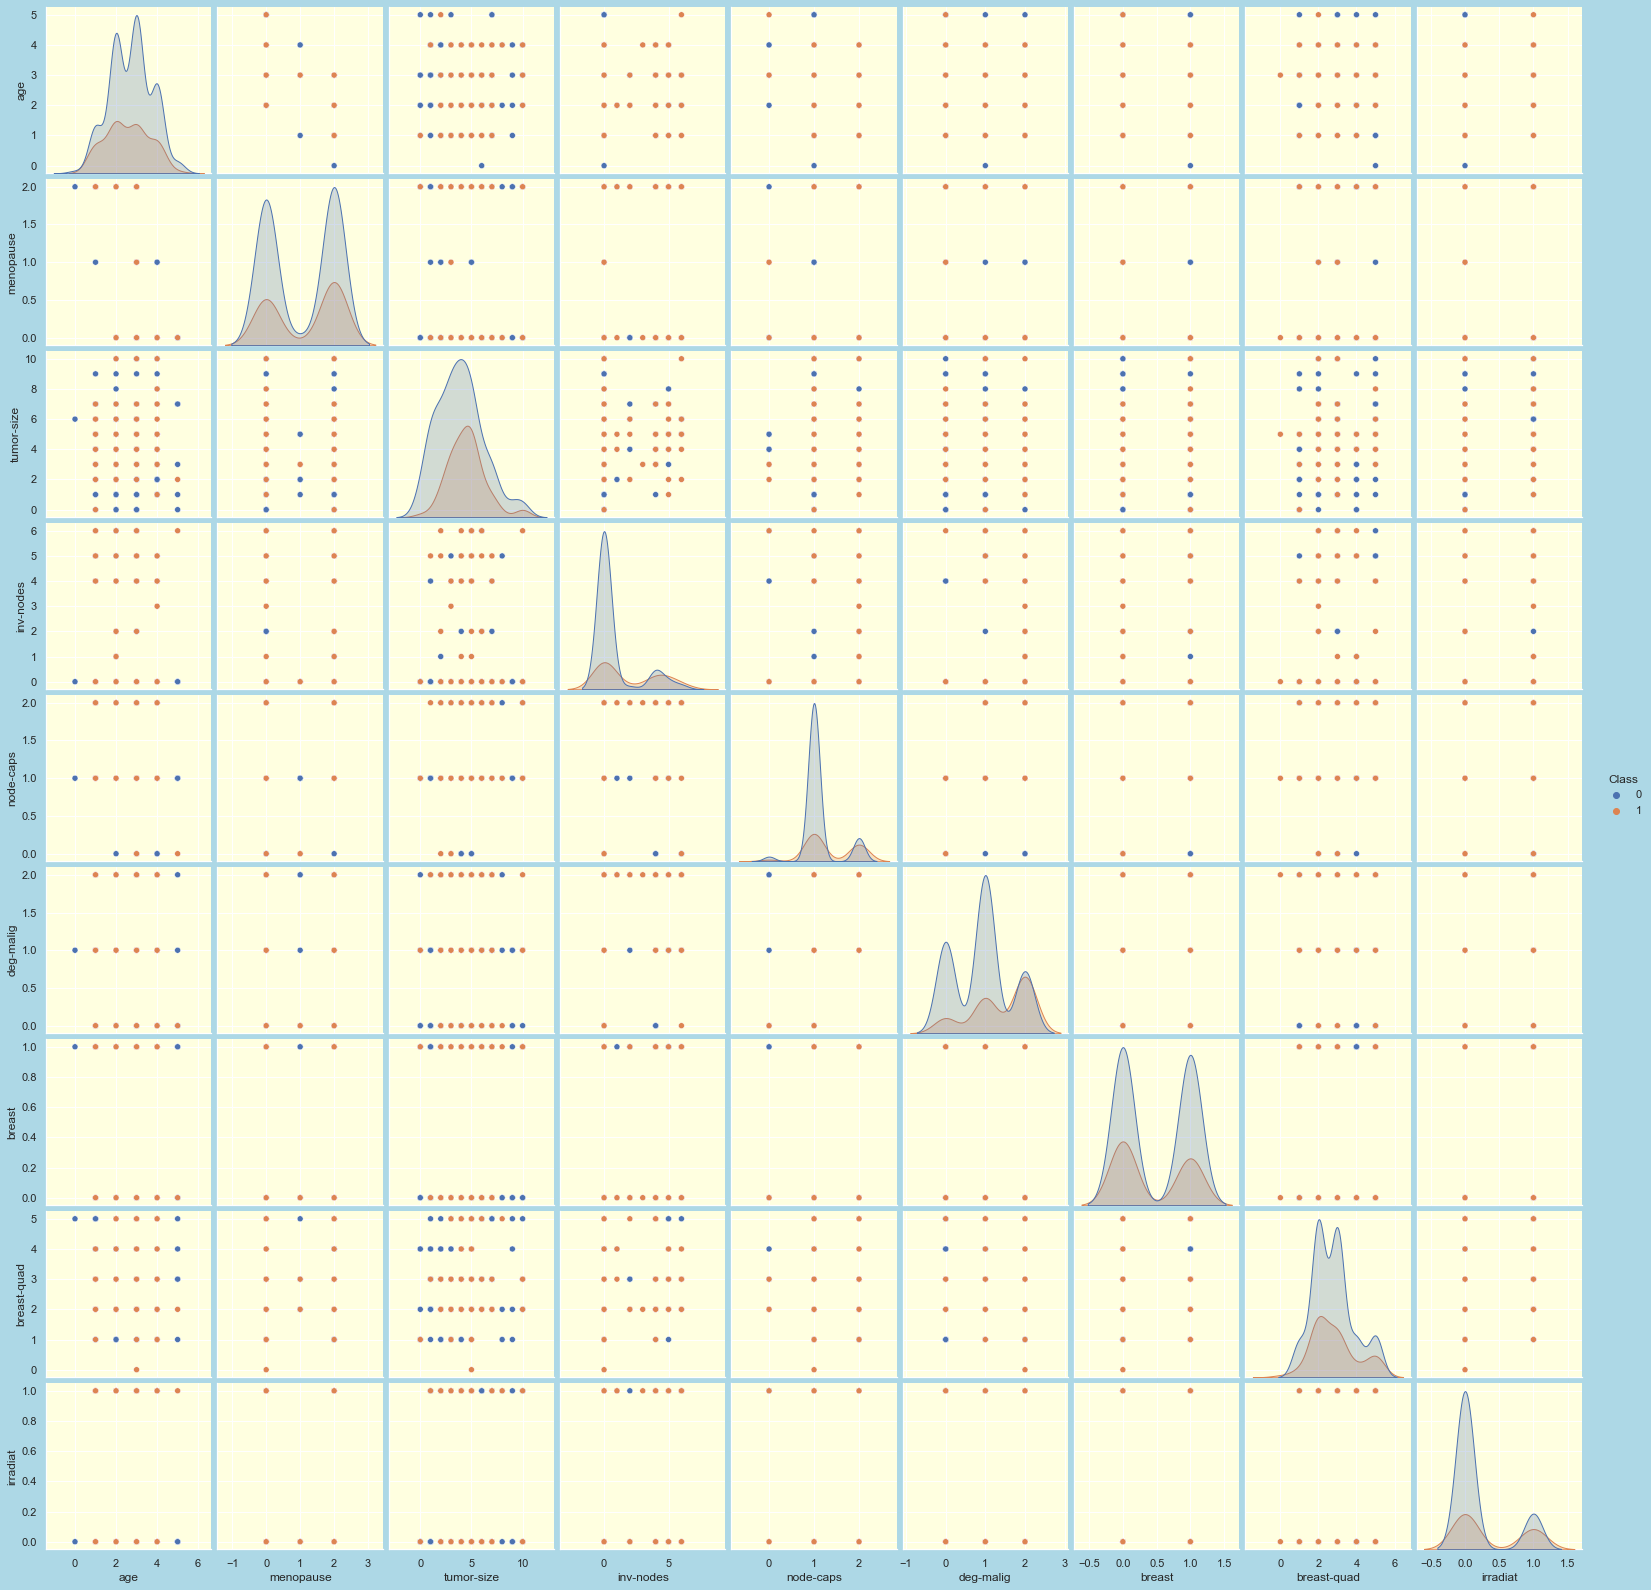

In [7]:
import seaborn as sns
sns.pairplot(data=data,hue='Class')

<AxesSubplot:>

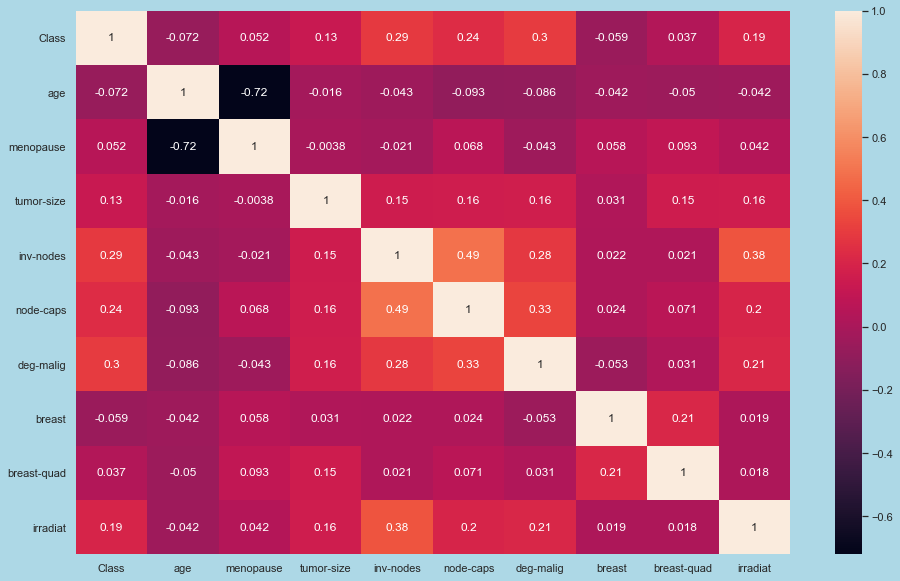

In [8]:
plt.figure(figsize=(16,10))
sns.heatmap(data.corr(),annot=True)

In [9]:
# Feature Selection

""" from sklearn.feature_selection import SelectKBest, chi2

chi2Features = SelectKBest(chi2,k=6)

X = data.drop("Class", axis=1).astype(int)
Y = data["Class"]
X =  chi2Features.fit_transform(X,Y)

print(X) """

' from sklearn.feature_selection import SelectKBest, chi2\n\nchi2Features = SelectKBest(chi2,k=6)\n\nX = data.drop("Class", axis=1).astype(int)\nY = data["Class"]\nX =  chi2Features.fit_transform(X,Y)\n\nprint(X) '

### Split the dataset into train and test sets (80:20)

In [10]:
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split

X = data.drop("Class", axis=1)
Y = data["Class"]
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=23)


print('Given data set==> {}'.format(data.shape))
print('Train data set==> {}'.format(X_train.shape))
print('Test data set==> {}'.format(X_test.shape))
# for use in roc analysis
y_test_bin = label_binarize(Y_test, classes=np.unique(Y_test))


Given data set==> (286, 10)
Train data set==> (228, 9)
Test data set==> (58, 9)


- Fitting data in sklearn GaussianNB and analyse performance

              precision    recall  f1-score   support

           0       0.84      0.82      0.83        45
           1       0.43      0.46      0.44        13

    accuracy                           0.74        58
   macro avg       0.63      0.64      0.64        58
weighted avg       0.75      0.74      0.74        58



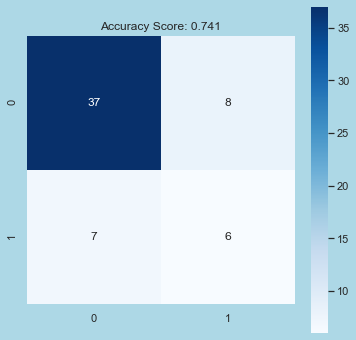

Overall Accuracy Score: 0.741
Classwise Accuracy Score: [0.74137931 0.74137931]


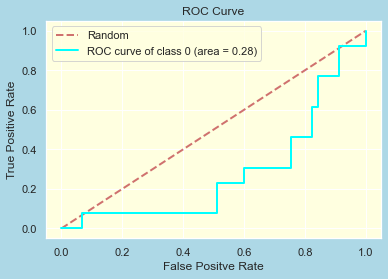

Area Under the curve for class 0 : 0.28034188034188035


In [11]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train, Y_train)
Y_pred_lib = model.predict(X_test)
y_score_lib = model.predict_proba(X_test)


print(metrics.classification_report(Y_test, Y_pred_lib))

confusionMatrixAndAccuracyReport(Y_test, Y_pred_lib)

rocCurveAndAucAnalysis(y_test_bin, y_score_lib)


### Q2. Now consider all features as correlated and construct a classifier using Mahalanobis distance. Draw analysis on the results by calculating the Roc curve, and classification report. Compare the results with part 1. You can refer to this article or book for Mahalanobis distance.
- Mahalanobis distance function

In [12]:
import scipy as sp
def mahalanobis(x=None, data=None, cov=None):
    """Compute the Mahalanobis Distance between each row of x and the data  
    x    : vector or matrix of data with, say, p columns.
    data : ndarray of the distribution from which Mahalanobis distance of each observation of x is to be computed.
    cov  : covariance matrix (p x p) of the distribution. If None, will be computed from data.
    """
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = sp.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

- Mahalanobis binary classifier

In [13]:
class MahalanobisBinaryClassifier():
    def __init__(self, xtrain, ytrain):
        self.xtrain_pos = xtrain.loc[ytrain == 1, :]
        self.xtrain_neg = xtrain.loc[ytrain == 0, :]

    def predict_proba(self, xtest):
        pos_neg_dists = [(p,n) for p, n in zip(mahalanobis(xtest, self.xtrain_pos), mahalanobis(xtest, self.xtrain_neg))]
        return np.array([(1-n/(p+n), 1-p/(p+n)) for p,n in pos_neg_dists])

    def predict(self, xtest):
        return np.array([np.argmax(row) for row in self.predict_proba(xtest)])


- Applying Mahalanobis Classifier on the given dataset and performance analysis

              precision    recall  f1-score   support

           0       0.88      0.62      0.73        45
           1       0.35      0.69      0.46        13

    accuracy                           0.64        58
   macro avg       0.61      0.66      0.59        58
weighted avg       0.76      0.64      0.67        58



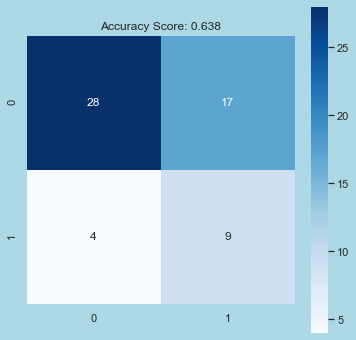

Overall Accuracy Score: 0.638
Classwise Accuracy Score: [0.63793103 0.63793103]


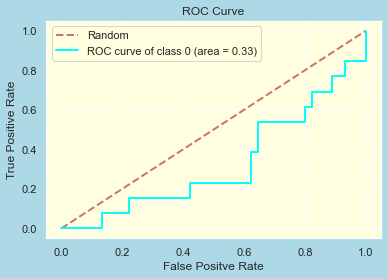

Area Under the curve for class 0 : 0.3264957264957265


In [14]:
clf = MahalanobisBinaryClassifier(X_train, Y_train)        
y_score_lib = clf.predict_proba(X_test)
Y_pred_lib = clf.predict(X_test)

print(metrics.classification_report(Y_test, Y_pred_lib))

confusionMatrixAndAccuracyReport(Y_test, Y_pred_lib)

rocCurveAndAucAnalysis(y_test_bin, y_score_lib)
